# Проект: Определение надежности заемщика

## Описание проекта

Банку необходимо определять надежность заемщика с целью минимизации вероятности просрочки при выдаче кредита.
Банк предоставил исторические данные с характеристиками заемщиков. 

**Цель исследования:**
Необходимо построить модель кредитного скоринга и определить вероятность, будет ли просрочен заемщиком платеж по кредиту на 90 дней или больше для определения надежности заемщика, а затем сделать вывод, выдавать ли кредит клиенту банка.

**Описание данных:** 
- Тренировочная выборка: `cs-training.csv`
- Тестовая выборка: `cs-test.csv`

**Признаки:**
- `SeriousDlqin2yrs` - Лицо, просрочившее платеж на 90 дней или больше (целевой признак)
- `RevolvingUtilizationOfUnsecuredLines` - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и задолженности без рассрочки, например, автокредитов, деленный на сумму кредитных лимитов
- `age` - Возраст заемщика в годах
- `NumberOfTime30-59DaysPastDueNotWorse` - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше за последние 2 года
- `DebtRatio` - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход
- `MonthlyIncome` - Ежемесячный доход
- `NumberOfOpenCreditLinesAndLoans` - Количество открытых кредитов (рассрочка, например, автокредит или ипотека) и кредитных линий (например, кредитные карты)
- `NumberOfTimes90DaysLate` - Количество раз, когда заемщик просрочил платеж на 90 дней или больше
- `NumberRealEstateLoansOrLines` - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья
- `NumberOfTime60-89DaysPastDueNotWorse` - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года
- `NumberOfDependents` - Количество иждивенцев в семье, за исключением себя (супруг(а), дети и т. д.)


**Ход исследования:**
1. **Загрузка и обзор данных.**
2. **Исследовательский анализ данных.** Изучим данные и сделаем выводы. Проведем корреляционный анализ.
3. **Обучение моделей.** Обучим модели , подберем для них гиперпараметры. Выбор лучшей модели сделаем на основе метрики ROC-AUC score. Определим, что данная метрика должна быть не меньше 0.85.
4. **Тестирование лучше модели на валидационной выборке.**
5. **Предсказания для тестовой выборки.**
6. **Выводы.**

## Загрузка и обзор данных

Импортируем библиотеки.

In [1]:
#установим библиотеки
!pip install scikit-learn==1.4.0
!pip install phik -q
!pip install xgboost
!pip install mycolorpy

#стандартные библиотеки
import os
import pandas as pd 
import numpy as np

#библиотеки и настройка для графиков
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from mycolorpy import colorlist as mcp
sns.set()

#класс для разделения на выборки
from sklearn.model_selection import train_test_split 

#загружаем класс для подготовки данных
from sklearn.preprocessing import StandardScaler

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы.

In [2]:
train_data = pd.read_csv('/Users/margarita/Desktop/datasets/cs-training.csv')
test_data = pd.read_csv('/Users/margarita/Desktop/datasets/cs-test.csv')

Выведем первые строки наборов данных. Изучим общую информацию о датафреймах.

In [3]:
#создадим функцию для выполнения обзора данных и применим ее к двум датафреймам
def data_view(data):
    display(data.head(5))
    data.info()

In [4]:
data_view(train_data)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [5]:
data_view(test_data)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [6]:
#переименуем столбец Unnamed: 0
train_data.rename(columns = {train_data.columns[0]:'ID'}, inplace = True) 
test_data.rename(columns = {test_data.columns[0]:'ID'}, inplace = True) 

In [7]:
#функция для проверки на пропуски дубликаты
def gap_duplicates(data):    
    print('Пропуски в данных:')
    print(data.isna().sum())
    print('\n')
    print('Количество явных дубликатов:', data.duplicated().sum())

In [8]:
gap_duplicates(train_data)

Пропуски в данных:
ID                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


Количество явных дубликатов: 0


In [9]:
gap_duplicates(test_data)

Пропуски в данных:
ID                                           0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64


Количество явных дубликатов: 0


В данных содержатся пропуски, определим их процент.

In [10]:
null = pd.DataFrame(train_data.isnull().sum(),columns=['количество пропусков'])
null['% пропущенных значений'] = round(train_data.isna().sum()/len(train_data)*100, 2)
null = null[null['% пропущенных значений'] > 0]
most_null = null.sort_values('% пропущенных значений', ascending=False)
most_null.style.background_gradient(cmap='Blues_r', low = 0.1, high = 0.2)

,количество пропусков,% пропущенных значений
MonthlyIncome,29731,19.820000
NumberOfDependents,3924,2.620000


In [11]:
null = pd.DataFrame(test_data.isnull().sum(),columns=['количество пропусков'])
null['% пропущенных значений'] = round(test_data.isna().sum()/len(test_data)*100, 2)
null = null[null['% пропущенных значений'] > 0]
most_null = null.sort_values('% пропущенных значений', ascending=False)
most_null.style.background_gradient(cmap='Blues_r', low = 0.1, high = 0.2)

,количество пропусков,% пропущенных значений
SeriousDlqin2yrs,101503,100.000000
MonthlyIncome,20103,19.810000
NumberOfDependents,2626,2.590000


Пропуски в столбце `MonthlyIncome` заполним медианой, а в столбце `NumberOfDependents` - наиболее часто встречающимся значением.

In [12]:
train_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median(),inplace=True)
test_data['MonthlyIncome'].fillna(test_data['MonthlyIncome'].median(),inplace=True)

In [13]:
train_data['NumberOfDependents'].fillna(train_data['NumberOfDependents'].mode()[0],inplace=True)
test_data['NumberOfDependents'].fillna(test_data['NumberOfDependents'].mode()[0],inplace=True)

**Выводы:**

Был выполнен обзор исторических банковских данных о клиентах. Все данные имеют корректные типы. Явных дубликатов не обнаружено. В данных присутствуют пропуски в столбцах `MonthlyIncome` и `NumberOfDependents`. Пропуски в столбце `MonthlyIncome` были заполнены медианой, а в столбце `NumberOfDependents` - модой.

### Исследовательский анализ данных

Осуществим анализ переменных в тренировочных и тестовых данных.

In [14]:
#выполним обзор данных для выбора количественных и качественных признаков
train_data.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [15]:
#вывод описательных статистик
train_data.describe().T.style.background_gradient(cmap='Blues_r', low = 0.1,high = 0.2)

,count,mean,std,min,25%,50%,75%,max
ID,150000.000000,75000.500000,43301.414527,1.000000,37500.750000,75000.500000,112500.250000,150000.000000
SeriousDlqin2yrs,150000.000000,0.066840,0.249746,0.000000,0.000000,0.000000,0.000000,1.000000
RevolvingUtilizationOfUnsecuredLines,150000.000000,6.048438,249.755371,0.000000,0.029867,0.154181,0.559046,50708.000000
age,150000.000000,52.295207,14.771866,0.000000,41.000000,52.000000,63.000000,109.000000
NumberOfTime30-59DaysPastDueNotWorse,150000.000000,0.421033,4.192781,0.000000,0.000000,0.000000,0.000000,98.000000
DebtRatio,150000.000000,353.005076,2037.818523,0.000000,0.175074,0.366508,0.868254,329664.000000
MonthlyIncome,150000.000000,6418.454920,12890.395542,0.000000,3903.000000,5400.000000,7400.000000,3008750.000000
NumberOfOpenCreditLinesAndLoans,150000.000000,8.452760,5.145951,0.000000,5.000000,8.000000,11.000000,58.000000
NumberOfTimes90DaysLate,150000.000000,0.265973,4.169304,0.000000,0.000000,0.000000,0.000000,98.000000
NumberRealEstateLoansOrLines,150000.000000,1.018240,1.129771,0.000000,0.000000,1.000000,2.000000,54.000000


In [16]:
#вывод описательных статистик
test_data.drop(columns=['SeriousDlqin2yrs'], axis=1).describe().T.style.background_gradient(cmap='Blues_r', low = 0.1,high = 0.2)

,count,mean,std,min,25%,50%,75%,max
ID,101503.000000,50752.000000,29301.536524,1.000000,25376.500000,50752.000000,76127.500000,101503.000000
RevolvingUtilizationOfUnsecuredLines,101503.000000,5.310000,196.156039,0.000000,0.030131,0.152586,0.564225,21821.000000
age,101503.000000,52.405436,14.779756,21.000000,41.000000,52.000000,63.000000,104.000000
NumberOfTime30-59DaysPastDueNotWorse,101503.000000,0.453770,4.538487,0.000000,0.000000,0.000000,0.000000,98.000000
DebtRatio,101503.000000,344.475020,1632.595231,0.000000,0.173423,0.364260,0.851619,268326.000000
MonthlyIncome,101503.000000,6566.861048,32699.094034,0.000000,3900.000000,5400.000000,7374.000000,7727000.000000
NumberOfOpenCreditLinesAndLoans,101503.000000,8.453514,5.144100,0.000000,5.000000,8.000000,11.000000,85.000000
NumberOfTimes90DaysLate,101503.000000,0.296691,4.515859,0.000000,0.000000,0.000000,0.000000,98.000000
NumberRealEstateLoansOrLines,101503.000000,1.013074,1.110253,0.000000,0.000000,1.000000,2.000000,37.000000
NumberOfTime60-89DaysPastDueNotWorse,101503.000000,0.270317,4.503578,0.000000,0.000000,0.000000,0.000000,98.000000


In [17]:
#рассмотрим цвета в выбранной палитре
color = mcp.gen_color(cmap="Blues_r",n=15)
print(color)

['#08306b', '#084387', '#0b559f', '#1967ad', '#2b7bba', '#3d8dc4', '#539ecd', '#6caed6', '#89bedc', '#a4cce3', '#bad6eb', '#cde0f1', '#dbe9f6', '#e9f2fa', '#f7fbff']


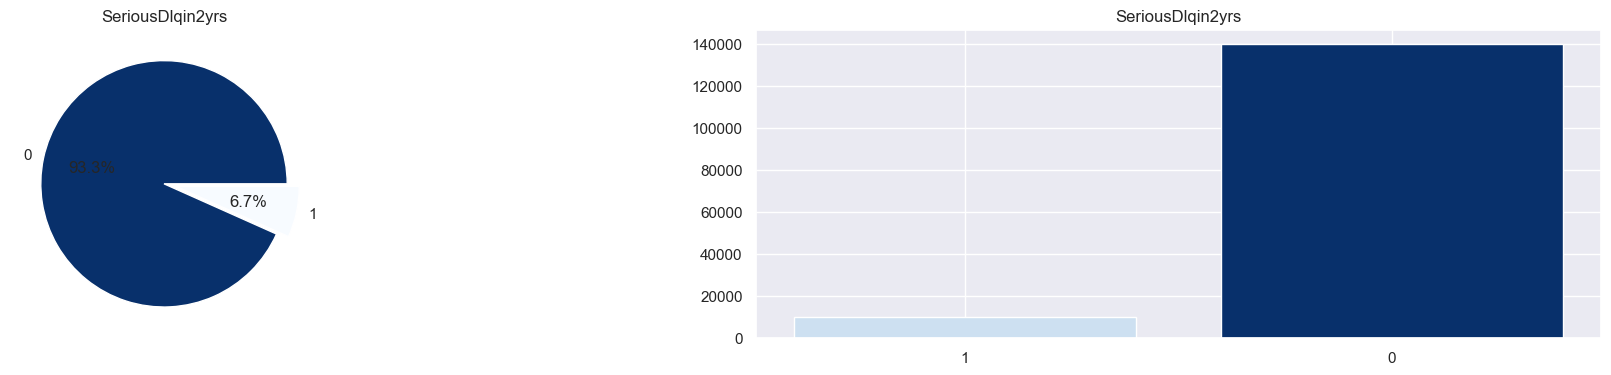

In [18]:
#рассмотрим соотношение целевого признака в данных
f,ax=plt.subplots(1,2,figsize=(24,4))
train_data['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=False, 
                                                       cmap='Blues_r')
ax[0].set_title('SeriousDlqin2yrs')
ax[0].set_ylabel('')


ax[1].bar(train_data['SeriousDlqin2yrs'].unique(), 
        train_data['SeriousDlqin2yrs'].value_counts(),
        tick_label = ['0', '1'], color=['#08306b', '#cde0f1'])


ax[1].set_title('SeriousDlqin2yrs')
plt.show()

In [19]:
#функция для построения гистограммы и боксплота
def graph_num_var(data, col_names):
    for col in col_names:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
        data[col].plot(kind='hist', bins=20, ax=axes[0], color='#08306b')
        axes[0].set_title(f'Гистограмма распределения признака \n "{col}"')
        axes[0].set_xlabel(f'{col}')
        axes[0].set_ylabel('Количество клиентов')
    
        data[col].plot(kind='box', ax=axes[1])
        axes[1].set_title(f'Разброс значений признака \n "{col}"')
        axes[1].set_ylabel('Значение признака')
        plt.show()

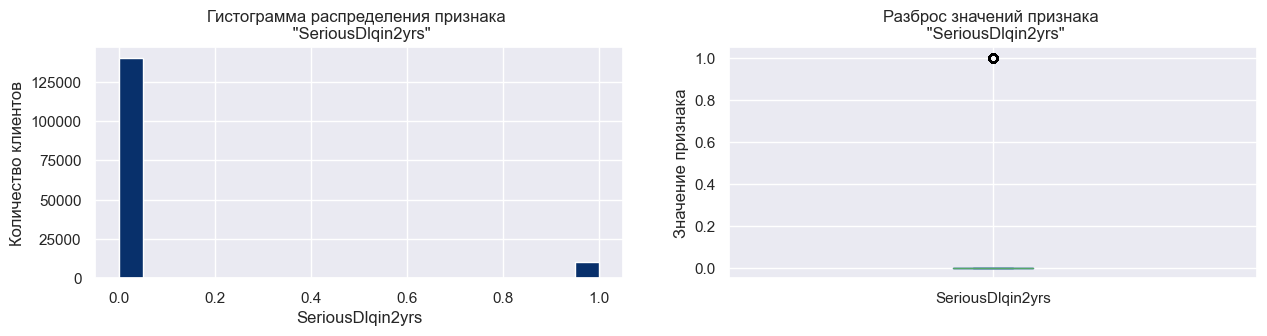

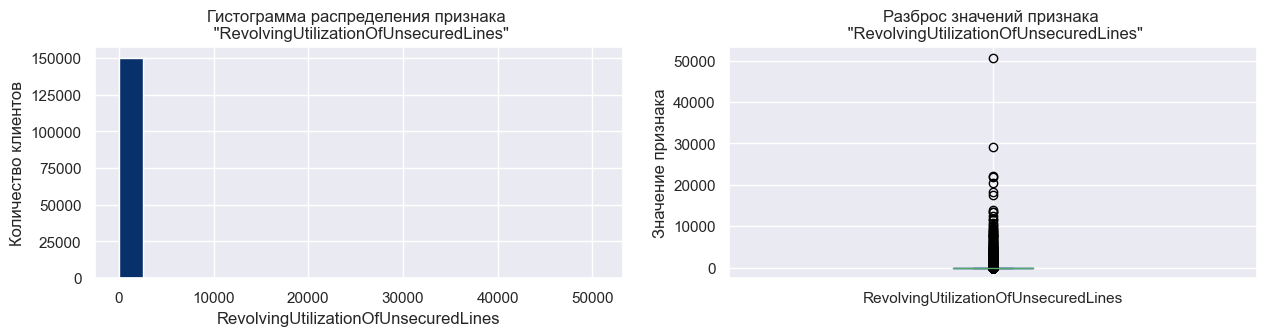

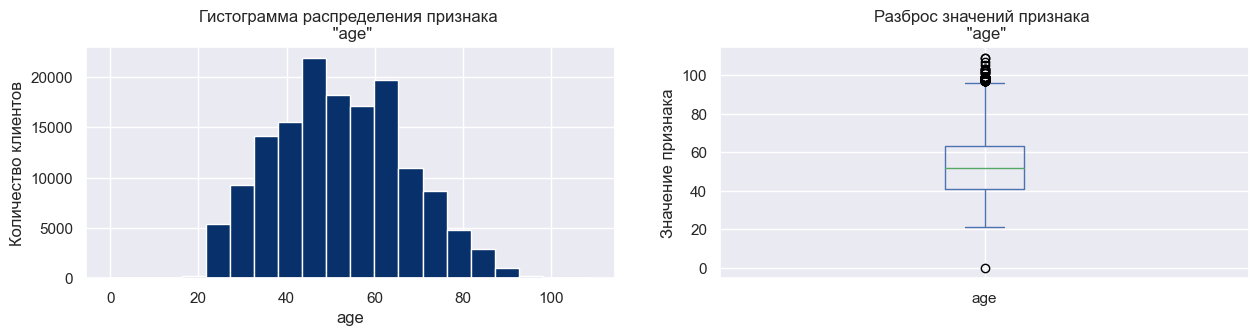

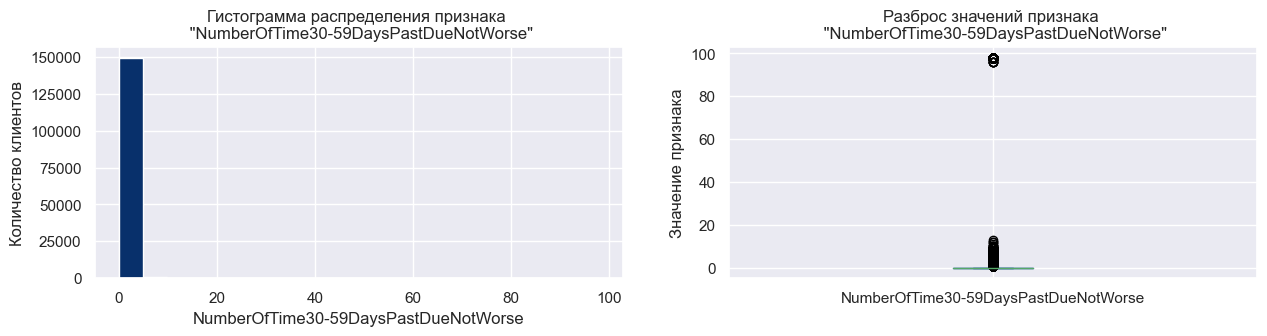

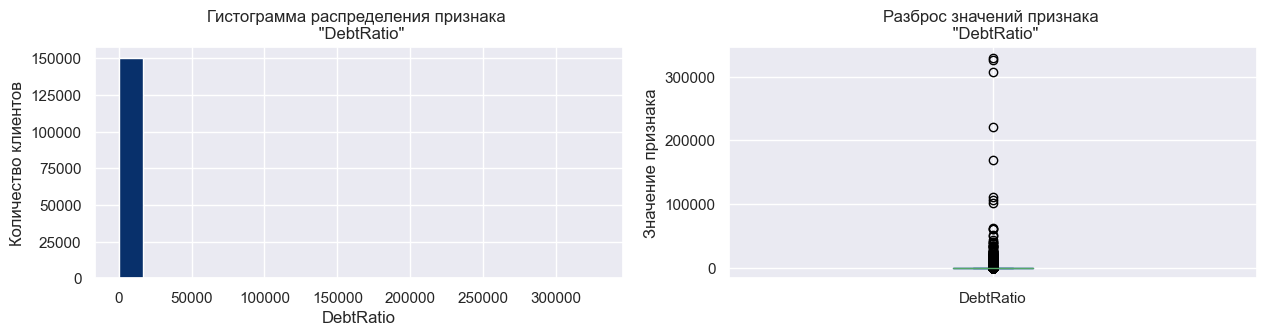

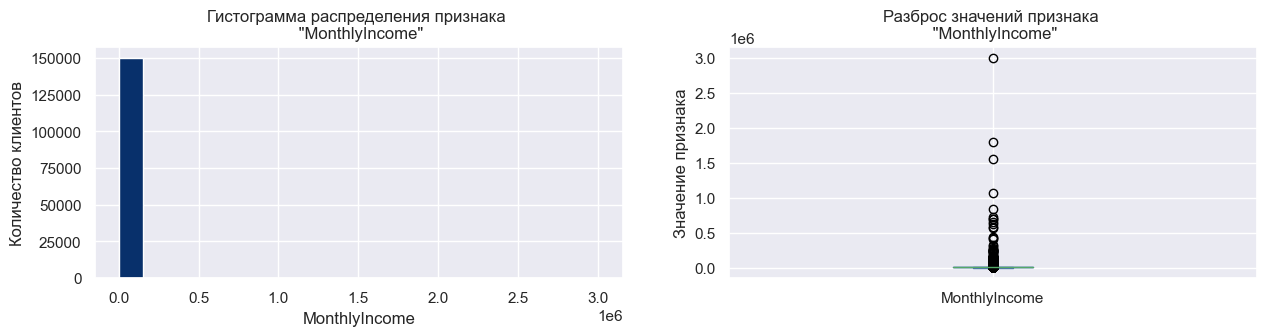

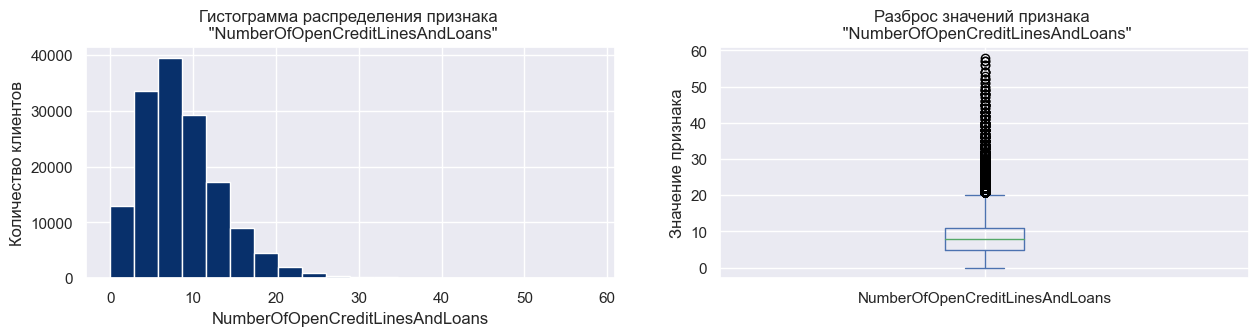

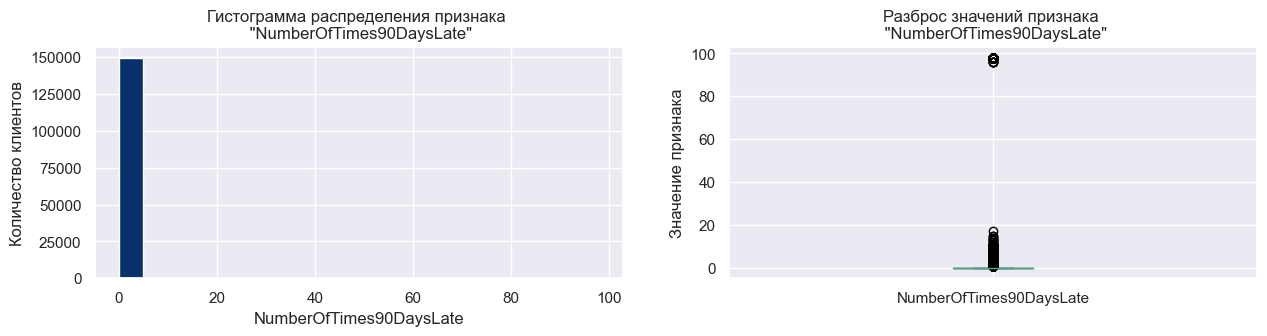

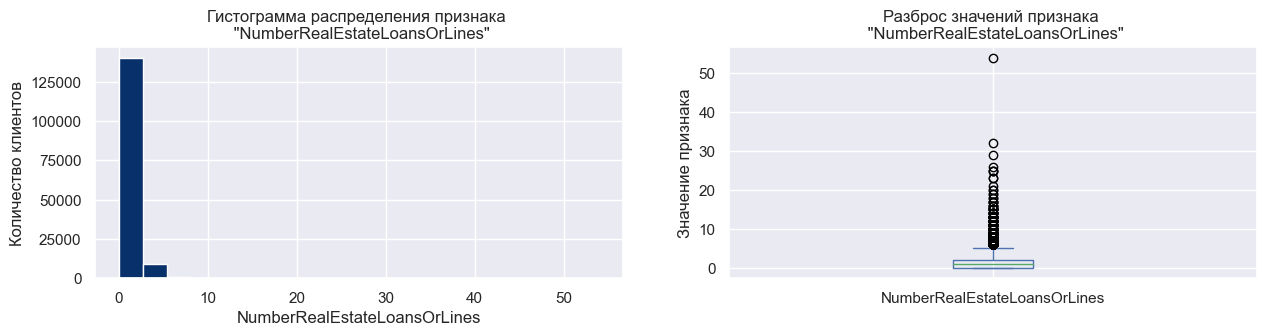

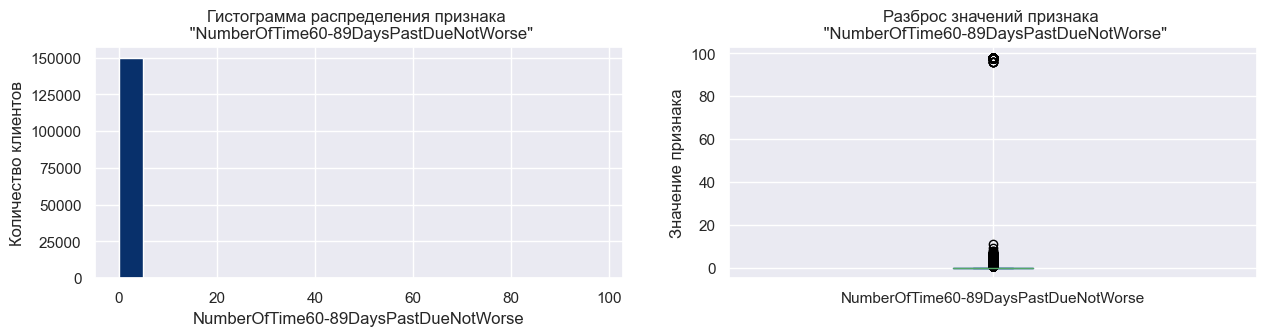

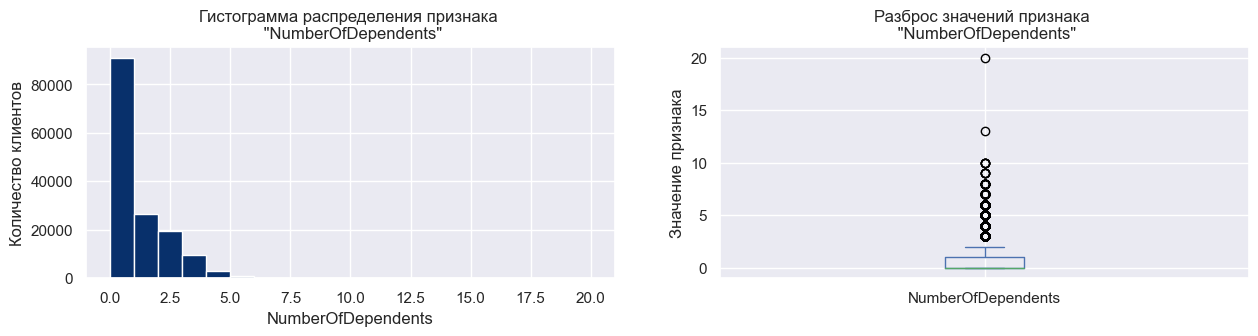

In [20]:
#количественные признаки
num_col_train = train_data.drop(columns=['ID'], axis=1).columns.to_list()

#построение гистограмм и боксплотов
graph_num_var(train_data, num_col_train)

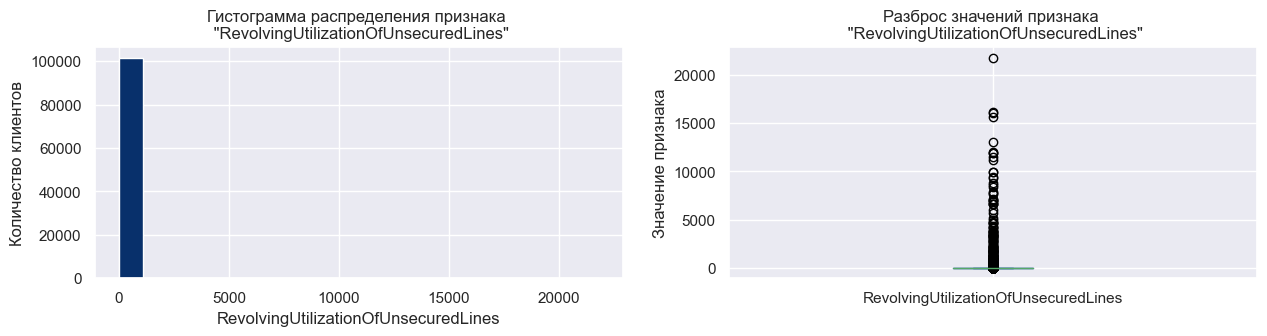

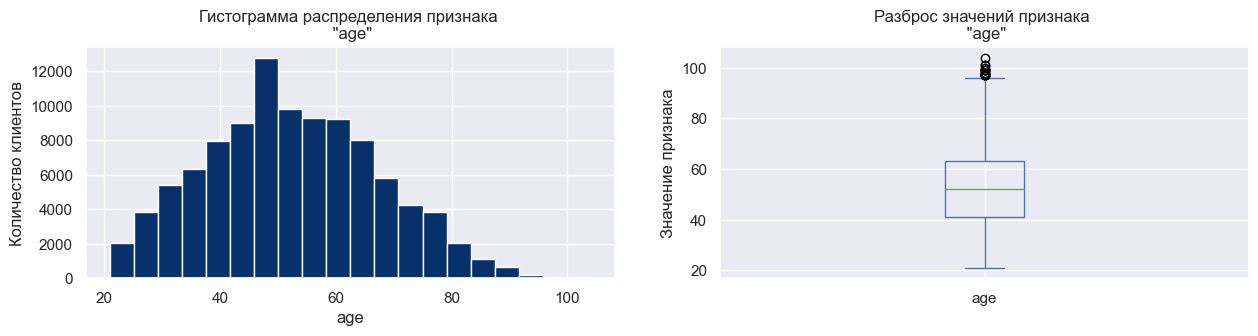

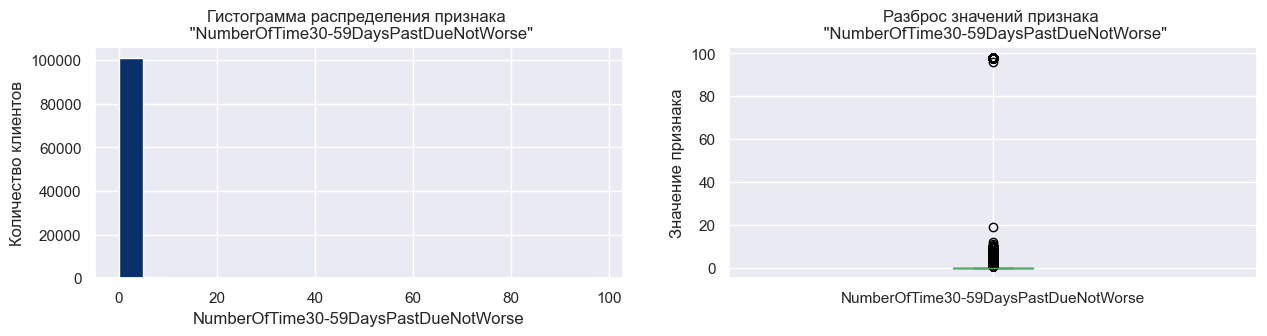

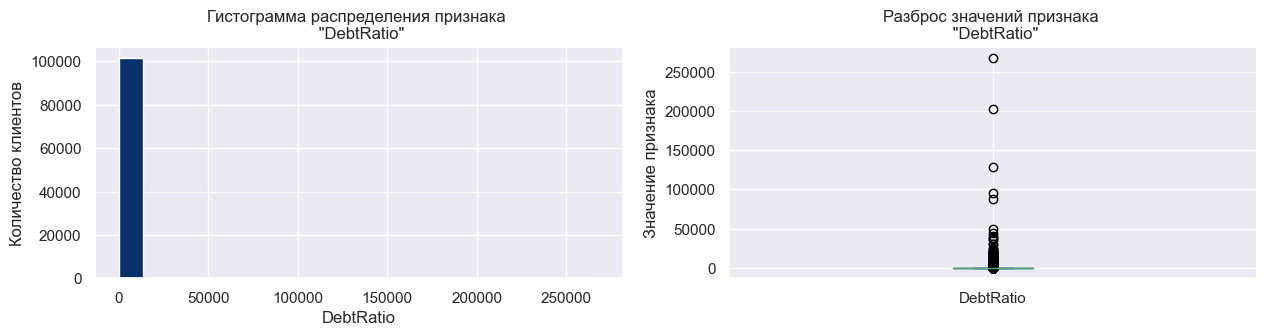

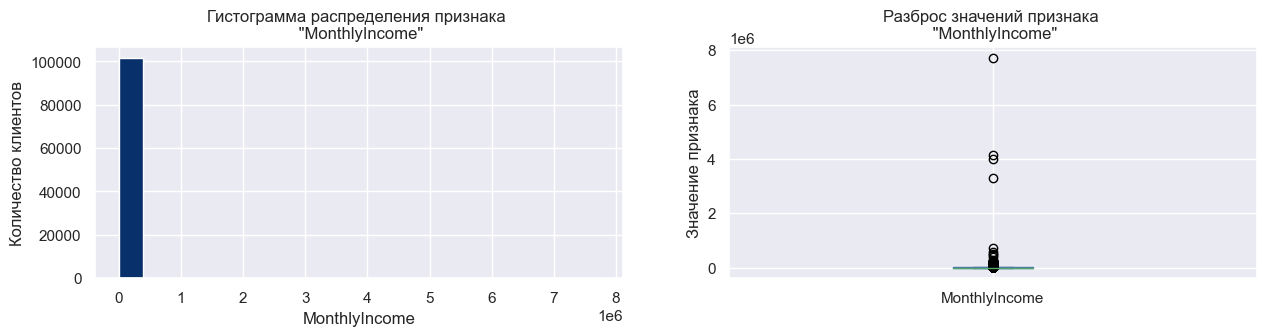

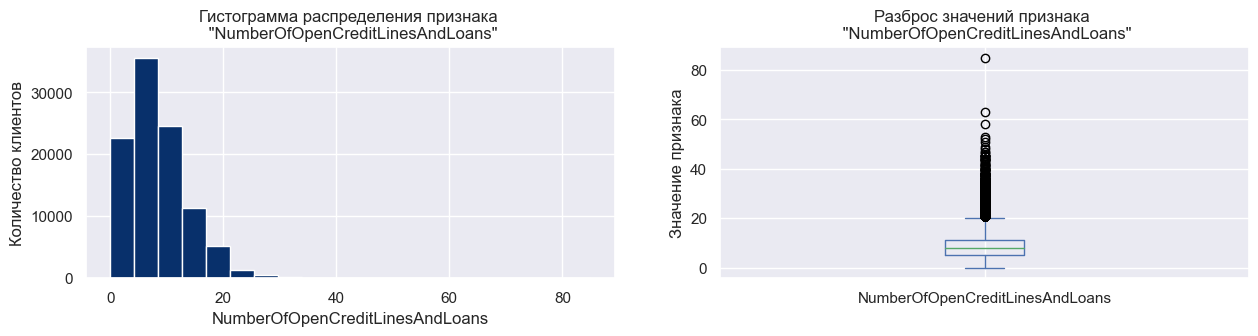

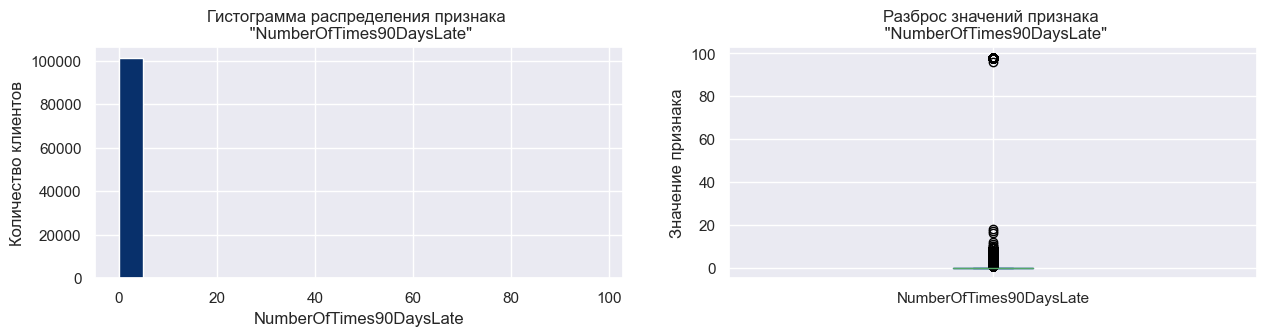

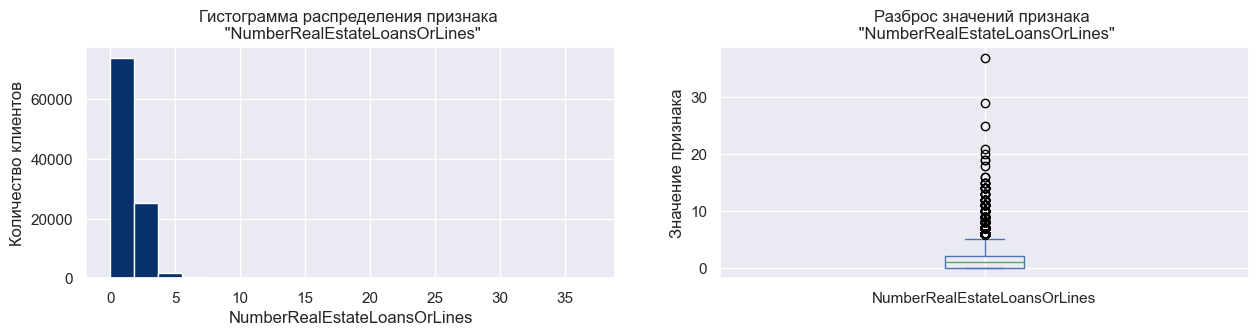

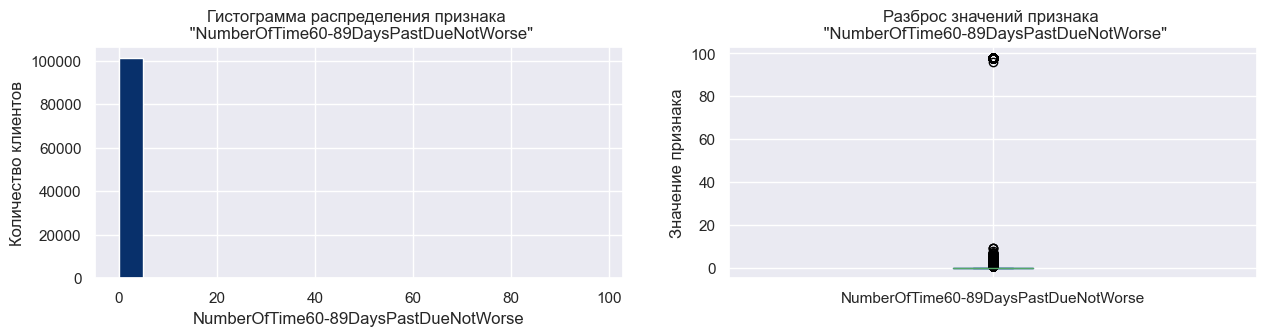

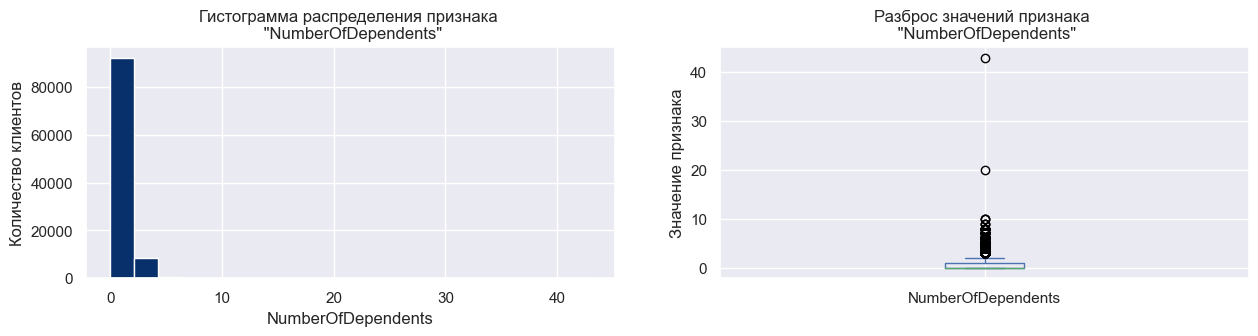

In [21]:
#количественные признаки
num_col_test = test_data.drop(columns=['SeriousDlqin2yrs', 'ID'], axis=1).columns.to_list()

#построение гистограмм и боксплотов
graph_num_var(test_data, num_col_test)

Исключим строки с аномальным значением возраста из тренировочных данных.

In [22]:
#стока при age=0
train_data[train_data['age']<18]

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [23]:
train_data = train_data.query('age>18').reset_index(drop=True)

#### Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

/Users/margarita/anaconda3/lib/python3.11/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 4199972. Are interval variables set correctly?
  warnings.warn(
/Users/margarita/anaconda3/lib/python3.11/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 8699942. Are interval variables set correctly?
  warnings.warn(
/Users/margarita/anaconda3/lib/python3.11/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 12749915. Are interval variables set correctly?
  warnings.warn(


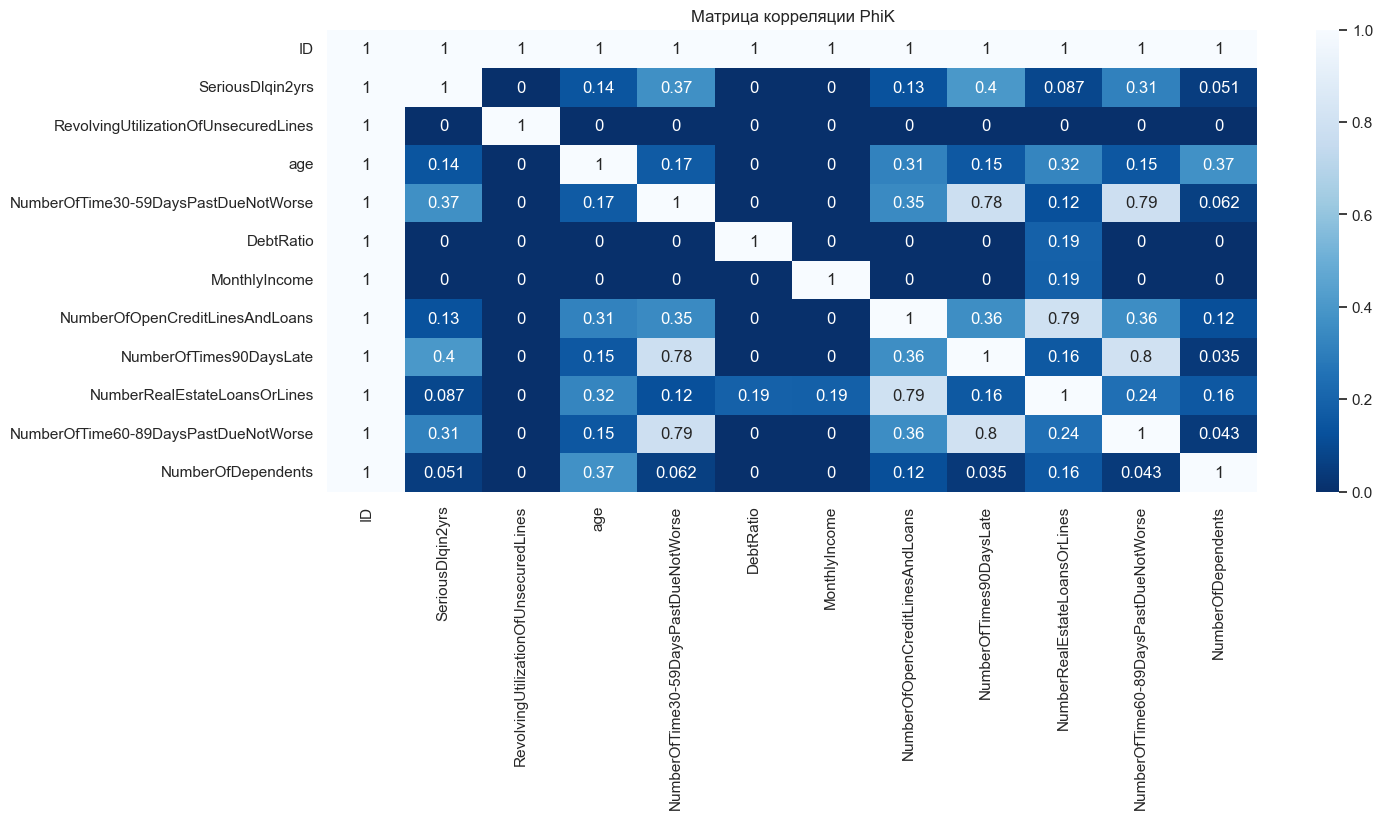

In [24]:
#вычислим матрицы корреляции с использованием phik
corr_matrix = train_data.phik_matrix(interval_cols=['MonthlyIncome',
                                                    'RevolvingUtilizationOfUnsecuredLines',
                                                    'DebtRatio'])

#визуализируем матрицы корреляции
plt.figure(figsize=(15, 6))

sns.heatmap(corr_matrix, annot=True, cmap='Blues_r')
plt.title('Матрица корреляции PhiK')
plt.show()

**Выводы:**

- Был проведен исследовательский анализ исторических банковских данных о заемщиках. Установлено, что число лиц, просрочивших платеж на 90 дней или больше (целевой признак), составляет 6.7%, в то время как надежных заемщиков без просрочек 93.3%. Было обнаружено и исключено аномальное значение по возрасту в тренировочных данных. Установлено, что средний возраст заемщика составляет около 52 лет. Количество иждивенцев в семье в среднем приближается к 1. При этом средний месячный доход составляет 6418 ед. для тренировочных данных и 6567 ед. для тестовых данных.
- Корреляционный анализ показал сильную связь с коэффициентами корреляции 0.78-0.8 для признаков: `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`, и `NumberOfTime60-89DaysPastDueNotWorse`; `NumberOfOpenCreditLinesAndLoans` и `NumberRealEstateLoansOrLines`. Однако не будем избавляться от какого-либо из признаков при дальнейшем моделировании, т.к. данная связь не настолько сильна, чтобы можно было пренебречь каким-то из признаков.

### Обучение моделей

In [25]:
test_data.drop(columns=['ID', 'SeriousDlqin2yrs'], axis=1).head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [26]:
X = train_data.drop(columns=['ID', 'SeriousDlqin2yrs'], axis=1)
y = train_data['SeriousDlqin2yrs']
X_test = test_data.drop(columns=['ID', 'SeriousDlqin2yrs'], axis=1)

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle = True)

In [28]:
print('Размер X_train:', X_train.shape)
print('Размер y_train:', y_train.shape)
print('Размер X_valid:', X_valid.shape)
print('Размер y_valid:', y_valid.shape)

Размер X_train: (104999, 10)
Размер y_train: (104999,)
Размер X_valid: (45000, 10)
Размер y_valid: (45000,)


In [29]:
#в датасете имеются только количественные признаки
#создадим переменную с экземпляром класса StandardScaler
scaler = StandardScaler()

#обучим и трансформируем количественные признаки из тренировочной выборки 
X_train = scaler.fit_transform(X_train)

#выполним преобразование количественных признаков в валидационной выборке
X_valid = scaler.transform(X_valid)

#### CatBoost

In [30]:
#зададим модель и параметры
cb = CatBoostClassifier(random_state=42, iterations=22)

cb_parameters = {
    'simple_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
    'combinations_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
    'max_depth': range(6, 12)
}

cb_gs = GridSearchCV(
    cb,
    cb_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [31]:
cb_gs.fit(X_train, y_train) 

Learning rate set to 0.5
0:	learn: 0.3921669	total: 69.4ms	remaining: 1.46s
1:	learn: 0.2856304	total: 79.7ms	remaining: 797ms
2:	learn: 0.2341894	total: 93.3ms	remaining: 591ms
3:	learn: 0.2086509	total: 104ms	remaining: 468ms
4:	learn: 0.1947189	total: 117ms	remaining: 397ms
5:	learn: 0.1871401	total: 126ms	remaining: 336ms
6:	learn: 0.1827732	total: 134ms	remaining: 288ms
7:	learn: 0.1807459	total: 151ms	remaining: 265ms
8:	learn: 0.1797917	total: 163ms	remaining: 236ms
9:	learn: 0.1792557	total: 172ms	remaining: 206ms
10:	learn: 0.1781294	total: 182ms	remaining: 182ms
11:	learn: 0.1776150	total: 191ms	remaining: 160ms
12:	learn: 0.1770862	total: 205ms	remaining: 142ms
13:	learn: 0.1768298	total: 215ms	remaining: 123ms
14:	learn: 0.1765471	total: 224ms	remaining: 104ms
15:	learn: 0.1762849	total: 234ms	remaining: 87.6ms
16:	learn: 0.1761449	total: 243ms	remaining: 71.4ms
17:	learn: 0.1759830	total: 249ms	remaining: 55.4ms
18:	learn: 0.1756946	total: 259ms	remaining: 40.9ms
19:	learn

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x14f410cd0>,
             n_jobs=-1,
             param_grid={'combinations_ctr': ['Buckets',
                                              'BinarizedTargetMeanValue',
                                              'Counter'],
                         'max_depth': range(6, 12),
                         'simple_ctr': ['Buckets', 'BinarizedTargetMeanValue',
                                        'Counter']},
             scoring='roc_auc')

In [32]:
print('Лучшая модель:', cb_gs.best_estimator_)
print('Лучшие гиперпараметры модели:', cb_gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(cb_gs.best_score_.round(4)))
roc_auc_cb = abs(cb_gs.best_score_.round(4))

Лучшая модель: <catboost.core.CatBoostClassifier object at 0x14c0fbc90>
Лучшие гиперпараметры модели: {'combinations_ctr': 'Buckets', 'max_depth': 8, 'simple_ctr': 'Buckets'}
Метрика лучшей модели при кросс-валидации: 0.8644


#### LGBM

In [33]:
#зададим модель и параметры
lgbm = LGBMClassifier(random_state=42, n_estimators=40)

lgbm_parameters = {
    'num_leaves':range(6, 10),
    'max_depth': range(6, 10),
}

lgbm_gs = GridSearchCV(
    lgbm,
    lgbm_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [34]:
lgbm_gs.fit(X_train, y_train) 

Learning rate set to 0.5
0:	learn: 0.3923502	total: 67.9ms	remaining: 1.42s
1:	learn: 0.2856382	total: 78.5ms	remaining: 785ms
2:	learn: 0.2333405	total: 89.1ms	remaining: 565ms
3:	learn: 0.2076864	total: 98.9ms	remaining: 445ms
4:	learn: 0.1947413	total: 114ms	remaining: 389ms
5:	learn: 0.1876808	total: 126ms	remaining: 336ms
6:	learn: 0.1833878	total: 139ms	remaining: 297ms
7:	learn: 0.1818062	total: 150ms	remaining: 263ms
8:	learn: 0.1807534	total: 166ms	remaining: 239ms
9:	learn: 0.1798817	total: 177ms	remaining: 212ms
10:	learn: 0.1790820	total: 186ms	remaining: 186ms
11:	learn: 0.1782718	total: 201ms	remaining: 167ms
12:	learn: 0.1777570	total: 214ms	remaining: 148ms
13:	learn: 0.1771510	total: 223ms	remaining: 127ms
14:	learn: 0.1768093	total: 230ms	remaining: 107ms
15:	learn: 0.1765757	total: 240ms	remaining: 90.2ms
16:	learn: 0.1764192	total: 253ms	remaining: 74.4ms
17:	learn: 0.1760997	total: 263ms	remaining: 58.3ms
18:	learn: 0.1759337	total: 274ms	remaining: 43.3ms
19:	lear

GridSearchCV(cv=5, estimator=LGBMClassifier(n_estimators=40, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(6, 10), 'num_leaves': range(6, 10)},
             scoring='roc_auc')

In [35]:
print('Лучшая модель:', lgbm_gs.best_estimator_)
print('Лучшие гиперпараметры модели:', lgbm_gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(lgbm_gs.best_score_.round(3)))
roc_auc_lgbm = abs(lgbm_gs.best_score_.round(4))

Лучшая модель: LGBMClassifier(max_depth=8, n_estimators=40, num_leaves=9, random_state=42)
Лучшие гиперпараметры модели: {'max_depth': 8, 'num_leaves': 9}
Метрика лучшей модели при кросс-валидации: 0.863


#### XGBoost

In [36]:
xgb = XGBClassifier(n_estimators=50, learning_rate= 0.1, scale_pos_weight=2)

xgb_parameters = {
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
    'max_depth': range(2, 10),
}

xgb_gs = GridSearchCV(
    xgb,
    xgb_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [37]:
xgb_gs.fit(X_train, y_train) 

6:	learn: 0.1779761	total: 219ms	remaining: 470ms
7:	learn: 0.1754507	total: 249ms	remaining: 435ms
8:	learn: 0.1734885	total: 283ms	remaining: 408ms
9:	learn: 0.1716884	total: 317ms	remaining: 381ms
10:	learn: 0.1707215	total: 349ms	remaining: 349ms
11:	learn: 0.1695097	total: 376ms	remaining: 313ms
12:	learn: 0.1687146	total: 409ms	remaining: 283ms
13:	learn: 0.1679999	total: 440ms	remaining: 251ms
14:	learn: 0.1672866	total: 484ms	remaining: 226ms
15:	learn: 0.1667388	total: 521ms	remaining: 195ms
16:	learn: 0.1661577	total: 548ms	remaining: 161ms
17:	learn: 0.1653034	total: 574ms	remaining: 128ms
18:	learn: 0.1648740	total: 599ms	remaining: 94.6ms
19:	learn: 0.1645500	total: 631ms	remaining: 63.1ms
20:	learn: 0.1641283	total: 654ms	remaining: 31.1ms
21:	learn: 0.1639452	total: 678ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3923515	total: 11.7ms	remaining: 245ms
1:	learn: 0.2837695	total: 23.8ms	remaining: 238ms
2:	learn: 0.2326022	total: 37.4ms	remaining: 237ms
3:	learn:

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'tree_method': ['auto', 'exact', 'approx', 'hist']},
             scoring='roc_auc')

In [38]:
print('Лучшая модель:', xgb_gs.best_estimator_)
print('Лучшие гиперпараметры модели:', xgb_gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(xgb_gs.best_score_.round(4)))
roc_auc_xgb = abs(xgb_gs.best_score_.round(4))

Лучшая модель: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Лучшие гиперпараметры модели: {'max_depth': 5, 'tree_method': 'auto'}
Метрика лучшей модели при кросс-валидации: 0.8643


#### Logistic Regression

In [39]:
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)

lr_parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear'],
    'C': [1.0, 0.001, 1000]
}

lr_gs = GridSearchCV(
    lr,
    lr_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [40]:
lr_gs.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': [1.0, 0.001, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [41]:
print('Лучшая модель:', lr_gs.best_estimator_)
print('Лучшие гиперпараметры модели:', lr_gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(lr_gs.best_score_.round(4)))
roc_auc_lr = abs(lr_gs.best_score_.round(4))

Лучшая модель: LogisticRegression(C=1000, class_weight='balanced', max_iter=500,
                   random_state=42)
Лучшие гиперпараметры модели: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Метрика лучшей модели при кросс-валидации: 0.7924


#### KNeighborsClassifier

In [42]:
knn = KNeighborsClassifier()

knn_parameters = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'n_neighbors': [5, 10, 15]
}

knn_gs = GridSearchCV(
    knn,
    knn_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [43]:
knn_gs.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [5, 10, 15],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [44]:
print('Лучшая модель:', knn_gs.best_estimator_)
print('Лучшие гиперпараметры модели:', knn_gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(knn_gs.best_score_.round(4)))
roc_auc_knn = abs(knn_gs.best_score_.round(4))

Лучшая модель: KNeighborsClassifier(algorithm='brute', n_neighbors=15, weights='distance')
Лучшие гиперпараметры модели: {'algorithm': 'brute', 'n_neighbors': 15, 'weights': 'distance'}
Метрика лучшей модели при кросс-валидации: 0.7332


#### DecisionTreeClassifier

In [45]:
dt = DecisionTreeClassifier(random_state=42)

dt_parameters = {
    'max_depth': range(2,10),
    'min_samples_split': range(2,5),
    'min_samples_leaf': range(2,5),
}

dt_gs = GridSearchCV(
    dt,
    dt_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [46]:
dt_gs.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 5)},
             scoring='roc_auc')

In [47]:
print('Лучшая модель:', dt_gs.best_estimator_)
print('Лучшие гиперпараметры модели:', dt_gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(dt_gs.best_score_.round(4)))
roc_auc_dt = abs(dt_gs.best_score_.round(4))

Лучшая модель: DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, random_state=42)
Лучшие гиперпараметры модели: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}
Метрика лучшей модели при кросс-валидации: 0.8467


#### RandomForest

In [48]:
rf = RandomForestClassifier(random_state=42)

rf_parameters = {
    'max_depth': range(2,6),
    'min_samples_split': range(2,6),
    'min_samples_leaf': range(2,6),
}

rf_gs = GridSearchCV(
    rf,
    rf_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

In [49]:
rf_gs.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(2, 6),
                         'min_samples_leaf': range(2, 6),
                         'min_samples_split': range(2, 6)},
             scoring='roc_auc')

In [50]:
print('Лучшая модель:', rf_gs.best_estimator_)
print('Лучшие гиперпараметры модели:', rf_gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(rf_gs.best_score_.round(4)))
roc_auc_rf = abs(rf_gs.best_score_.round(4))

Лучшая модель: RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=42)
Лучшие гиперпараметры модели: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Метрика лучшей модели при кросс-валидации: 0.8589


**Выводы:**
- С целью предсказания просрочки по кредиту были обучены и оптимизированы модели модели классификации: CatBoost, LGBM, XGBoost, Logistic Regression, KNeighbors, DecisionTreeClassifier, RandomForest. Был выполнен подбро гиперпараметров для лучшей модели с помощью Grid Search. В качестве метрики качества была выбрана ROC AUC. Были получены следующие значения ROC AUC для обученных моделей:

In [51]:
print('Метрика лучшей модели CatBoost:', roc_auc_cb)
print('Метрика лучшей модели LGBM:', roc_auc_lgbm)
print('Метрика лучшей модели XGBoost:', roc_auc_xgb)
print('Метрика лучшей модели Logistic Regression:', roc_auc_lr)
print('Метрика лучшей модели KNeighbors:', roc_auc_knn)
print('Метрика лучшей модели DecisionTreeClassifier:', roc_auc_dt)
print('Метрика лучшей модели RandomForest', roc_auc_rf)

Метрика лучшей модели CatBoost: 0.8644
Метрика лучшей модели LGBM: 0.8629
Метрика лучшей модели XGBoost: 0.8643
Метрика лучшей модели Logistic Regression: 0.7924
Метрика лучшей модели KNeighbors: 0.7332
Метрика лучшей модели DecisionTreeClassifier: 0.8467
Метрика лучшей модели RandomForest 0.8589


- Таким образом, была выбрана лучшая модель для дальнейшего тестирования на валидационной выборке: CatBoost.

### Тестирование лучшей модели на валидационной выборке

In [52]:
y_valid_pred = cb_gs.best_estimator_.predict(X_valid)
y_valid_pred = pd.DataFrame(y_valid_pred)
y_valid_pred.value_counts()

0    44012
1      988
Name: count, dtype: int64

In [53]:
y_valid_pred.head(3)

,0
0,0
1,0
2,0


In [54]:
#рассчитаем вероятности
#первое значение = вероятность того, что платеж НЕ будет просрочен, т.е. вероятность надежности заемщика
#второе значение = вероятность того, что платеж будет просрочен
y_valid_pred_proba = cb_gs.best_estimator_.predict_proba(X_valid)
y_valid_pred_proba

array([[0.9932238 , 0.0067762 ],
       [0.99107602, 0.00892398],
       [0.98997647, 0.01002353],
       ...,
       [0.94909272, 0.05090728],
       [0.99272882, 0.00727118],
       [0.97872252, 0.02127748]])

Метрика ROC-AUC лучшей модели на валидационной выборке: 0.8649


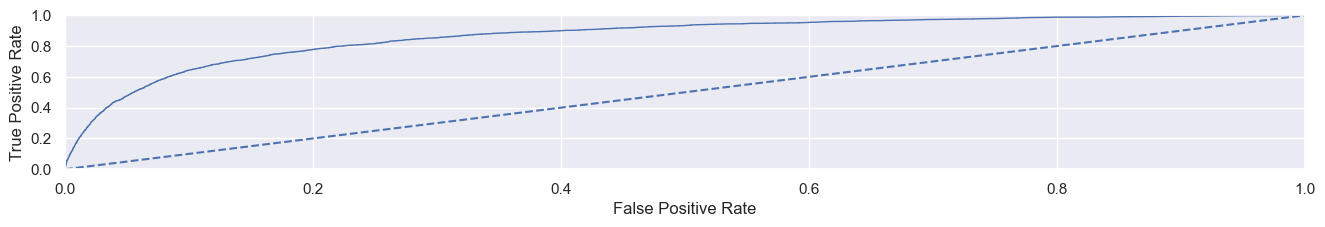

In [55]:
#выполним визуализацию ROC-кривой
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(16,2))
    plt.plot(fpr, tpr, linewidth=1, label=label)
    plt.plot([0,1],[0,1], 'b--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

y_valid_proba = y_valid_pred_proba[:,1]
fpr, tpr, thresh = roc_curve(y_valid, y_valid_proba)
plot_roc_curve(fpr, tpr)

print ('Метрика ROC-AUC лучшей модели на валидационной выборке:', 
       roc_auc_score(y_valid, y_valid_pred_proba[:,1]).round(4))

**Выводы:**
- Лучшая модель была протестирована на валидационной выборке. Метрика ROC-AUC лучшей модели на валидационной выборке составила 0.8649 и подтвердила надежность выбранной модели.

## Предсказания для тестовой выборки

In [56]:
y_test_pred = cb_gs.best_estimator_.predict(X_test)
y_test_pred = pd.DataFrame(y_test_pred, columns = ['Платеж будет просрочен (0 - нет, 1 - да)'])
y_test_pred.value_counts()

Платеж будет просрочен (0 - нет, 1 - да)
0                                           95766
1                                            5737
Name: count, dtype: int64

In [69]:
#рассчитаем вероятности
#первое значение = вероятность того, что платеж НЕ будет просрочен, т.е. вероятность надежности заемщика
#второе значение = вероятность того, что платеж будет просрочен
y_test_pred_proba = cb_gs.best_estimator_.predict_proba(X_test)
y_test_pred_proba = pd.DataFrame(y_test_pred_proba[:,1], 
                                 columns = ['Вероятность просрочки платежа по кредиту на 90 дней или больше'])

In [76]:
result = pd.concat([y_test_pred, y_test_pred_proba], axis=1)
result['Выдать кредит (0 - нет, 1 - да)'] = 1 - result['Платеж будет просрочен (0 - нет, 1 - да)']
result.sample(3)

,"Платеж будет просрочен (0 - нет, 1 - да)",Вероятность просрочки платежа по кредиту на 90 дней или больше,"Выдать кредит (0 - нет, 1 - да)"
45997,0,0.131420,1
13402,0,0.330630,1
23783,1,0.796133,0


**Выводы:**
- Лучшая модель была применена для предсказания надежности заемщика. Мы получили вероятность просрочки платежа по кредиту на 90 дней или больше. Далее из вероятности просрочки платежа по кредиту сделали вывод, выдавать данному клиенту кредит или нет.

## Выводы

- Был выполнен обзор исторических банковских данных о клиентах. Все данные имеют корректные типы. Явных дубликатов не обнаружено. В данных присутствуют пропуски в столбцах `MonthlyIncome` и `NumberOfDependents`. Пропуски в столбце `MonthlyIncome` были заполнены медианой, а в столбце `NumberOfDependents` - модой.
- Был проведен исследовательский анализ исторических банковских данных о заемщиках. Установлено, что число лиц, просрочивших платеж на 90 дней или больше (целевой признак), составляет 6.7%, в то время как надежных заемщиков без просрочек 93.3%. Было обнаружено и исключено аномальное значение по возрасту в тренировочных данных. Установлено, что средний возраст заемщика составляет около 52 лет. Количество иждивенцев в семье в среднем приближается к 1. При этом средний месячный доход составляет 6418 ед. для тренировочных данных и 6567 ед. для тестовых данных.
- Корреляционный анализ показал сильную связь с коэффициентами корреляции 0.78-0.8 для признаков: `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`, и `NumberOfTime60-89DaysPastDueNotWorse`; `NumberOfOpenCreditLinesAndLoans` и `NumberRealEstateLoansOrLines`. Однако принято решение не избавляться от какого-либо из признаков при дальнейшем моделировании, т.к. данная связь не настолько сильна, чтобы можно было пренебречь каким-то из признаков.
- С целью предсказания просрочки по кредиту были обучены и оптимизированы модели модели классификации: CatBoost, LGBM, XGBoost, Logistic Regression, KNeighbors, DecisionTreeClassifier, RandomForest. Был выполнен подбро гиперпараметров для лучшей модели с помощью Grid Search. В качестве метрики качества была выбрана ROC AUC. Были получены следующие значения ROC AUC для обученных моделей:
  - Метрика лучшей модели CatBoost: 0.8644
  - Метрика лучшей модели LGBM: 0.8629
  - Метрика лучшей модели XGBoost: 0.8643
  - Метрика лучшей модели Logistic Regression: 0.7924
  - Метрика лучшей модели KNeighbors: 0.7332
  - Метрика лучшей модели DecisionTreeClassifier: 0.8467
  - Метрика лучшей модели RandomForest 0.8589
- Таким образом, была выбрана лучшая модель для дальнейшего тестирования на валидационной выборке: CatBoost.
- Лучшая модель была протестирована на валидационной выборке. Метрика ROC-AUC лучшей модели на валидационной выборке составила 0.8649 и подтвердила надежность выбранной модели.
- Лучшая модель была применена для предсказания надежности заемщика. Мы получили вероятность просрочки платежа по кредиту на 90 дней или больше. Далее из вероятности просрочки платежа по кредиту сделали вывод, выдавать данному клиенту кредит или нет.